# Machine Learning to Identify Fraud in the Enron Corpus

In [2]:
import warnings 
warnings.filterwarnings("ignore")
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Task 1: Select what features you'll use

features_list is a list of strings, each of which is a feature name.    
The first feature must be "poi".    
features_list = ['poi','salary']    
**You will need to use more features**

In [3]:
target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

In [4]:
### Load the dictionary containing the dataset

with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [5]:
df = pd.DataFrame(data_dict)
#df['LOCKHART EUGENE E']
df.T

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292
CAUSEY RICHARD A,415189,1892,NaN,1868758,NaN,1000000,richard.causey@enron.com,NaN,-235000,2502063,...,58,NaN,49,307895,12,True,350000,1585,2502063,NaN
TAYLOR MITCHELL S,265214,533,227449,1092663,NaN,600000,mitchell.taylor@enron.com,NaN,NaN,3745048,...,0,3181250,29,NaN,0,False,NaN,300,563798,NaN
DONAHUE JR JEFFREY M,278601,865,NaN,875760,NaN,800000,jeff.donahue@enron.com,NaN,-300000,1080988,...,188,765920,22,891,11,False,NaN,772,315068,NaN


### 1.1.0 Explore csv file 

In [6]:
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration

In [7]:
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))

# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


### 1.1.2 Feature Exploration

In [8]:
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

Each person has 21 features available


### Print results of completeness analysis

In [9]:
print('Number of Missing Values for Each Feature:')

#sorted(missing_values.values())

#for feature in all_features:
   # print("%s: %d" % (feature, sorted(missing_values.values())[feature])


for id in sorted(missing_values, key = missing_values.get, reverse = True):
          print(id, missing_values[id])


Number of Missing Values for Each Feature:
loan_advances 142
director_fees 129
restricted_stock_deferred 128
deferral_payments 107
deferred_income 97
long_term_incentive 80
bonus 64
to_messages 60
from_poi_to_this_person 60
from_messages 60
from_this_person_to_poi 60
shared_receipt_with_poi 60
other 53
salary 51
expenses 51
exercised_stock_options 44
restricted_stock 36
email_address 35
total_payments 21
total_stock_value 20
poi 0


=> classification,we have here unblanced target. 
Maybe Smot methodology ? 

## Task 2: Remove outliers

In [10]:
def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

### 2.1 Visualise outliers

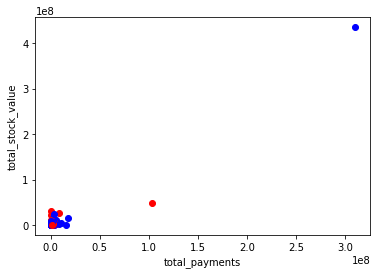

None


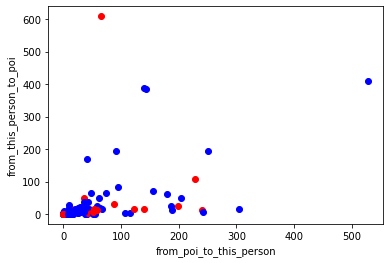

None


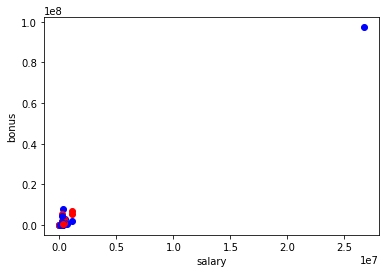

None


{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [11]:
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )

### 2.2 Function to remove outliers

In [12]:
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)

=>Remove columns   
Maybe more outliers ? 

### Task 3: Create new feature(s)

### 3.1 create new copies of dataset for grading

In [13]:
my_dataset = data_dict

### 3.2 add new features to dataset

In [14]:
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = poi_messages / all_messages
    return fraction

In [15]:
for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
    
    shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
    shared_receipt_poi_ratio = compute_fraction(shared_receipt_with_poi, to_messages)
    data_point["shared_receipt_poi_ratio"] = shared_receipt_poi_ratio
    
    bonus= data_point["bonus"]
    salary = data_point["salary"]
    bonus_to_salary = compute_fraction(bonus, salary)
    data_point["bonus_to_salary"] = bonus_to_salary  
    
    total_payments = data_point["total_payments"]
    bonus_to_salary = compute_fraction(total_payments, salary)
    data_point["bonus_to_total"] = bonus_to_salary  
    
    x = float(from_poi_to_this_person) + float(from_this_person_to_poi)
    y = float(from_messages) + float(to_messages)
    ratio_mess= compute_fraction(x,y)
    data_point["ratio_mess"] = ratio_mess 

In [16]:
for name in my_dataset:
    data_point = my_dataset[name]
    direction = 0 
    data_point["direction"] = direction 

In [17]:



list_direction2 = ["LAY KENNETH L","SKILLING JEFFREY K"]
list_direction1 = ["BUY RICHARD B","CAUSEY RICHARD A","DERRICK JR. JAMES V","KEAN STEVEN J","KOENIG MARK E","METTS MARK","FASTOW ANDREW S","BAXTER JOHN C","HORTON STANLEY C","FREVERT MARK A","WHALLEY LAWRENCE G","PAI LOU L","WHITE JR THOMAS E","HIRKO JOSEPH","RICE KENNETH D"]
data_point = my_dataset[name]
for name in my_dataset : 
    for item in list_direction1 :
        if name == item : 
            direction = 1
            my_dataset[name]['direction'] = direction
    for item2 in list_direction2 :
        if name == item2 : 
            direction = 2
            my_dataset[name]['direction'] = direction


In [18]:
my_dataset['LAY KENNETH L']

{'salary': 1072321,
 'to_messages': 4273,
 'deferral_payments': 202911,
 'total_payments': 103559793,
 'loan_advances': 81525000,
 'bonus': 7000000,
 'email_address': 'kenneth.lay@enron.com',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': -300000,
 'total_stock_value': 49110078,
 'expenses': 99832,
 'from_poi_to_this_person': 123,
 'exercised_stock_options': 34348384,
 'from_messages': 36,
 'other': 10359729,
 'from_this_person_to_poi': 16,
 'poi': True,
 'long_term_incentive': 3600000,
 'shared_receipt_with_poi': 2411,
 'restricted_stock': 14761694,
 'director_fees': 'NaN',
 'fraction_from_poi': 0.028785396676807865,
 'fraction_to_poi': 0.4444444444444444,
 'shared_receipt_poi_ratio': 0.5642405803884858,
 'bonus_to_salary': 6.527896031132468,
 'bonus_to_total': 96.57536595851428,
 'ratio_mess': 0.03225806451612903,
 'direction': 2}

=> Maybe new features ? 

### 3.3 create new copies of feature list for grading

In [19]:
my_feature_list = features_list +['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi','shared_receipt_poi_ratio','bonus_to_salary','bonus_to_total','direction']

### 3.4 get K-best features

In [20]:
num_features = 10

### 3.5 function using SelectKBest

In [21]:
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features

=> Maybe appropriate stat test for classification. 

In [22]:
best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))


[20.79225205  0.22461127 11.45847658  2.1263278  24.81507973  6.09417331
  7.18405566  9.92218601  4.18747751  9.21281062  0.06549965 18.28968404
  8.77277773 24.18289868  0.16970095  5.24344971  2.38261211  8.58942073
  1.64634113  1.64634113  5.24344971  0.16970095  2.38261211  8.58942073
 16.40971255  9.10126874 10.78358471  0.05269769 22.11011023]
10 best features: dict_keys(['exercised_stock_options', 'total_stock_value', 'direction', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'bonus_to_salary', 'long_term_incentive', 'restricted_stock'])



### 3.6 print features

In [23]:
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

10 selected features: ['long_term_incentive', 'fraction_to_poi', 'restricted_stock', 'direction', 'total_stock_value', 'exercised_stock_options', 'bonus', 'salary', 'bonus_to_salary', 'deferred_income']



### 3.7 extract the features specified in features_list


In [24]:
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)

split into labels and features

In [25]:
labels, features = targetFeatureSplit(data)

### 3.8 scale features via min-max

In [26]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

## Task 4: Using algorithm

Please name your classifier clf for easy export below.   
Note that if you want to do PCA or other multi-stage operations,    
you'll need to use Pipelines. For more info:    
http://scikit-learn.org/stable/modules/pipeline.html     

Provided to give you a starting point. Try a variety of classifiers.   

### 4.1  Gaussian Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

### 4.2  Logistic Regression Classifier


In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

### 4.3  K-means Clustering

In [30]:
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

### 4.4 Support Vector Machine Classifier

In [31]:
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

### 4.5 Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)

### 4.6 Gradient Boosting Classifier

In [33]:
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

### 4.7 Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
tre_clf=DecisionTreeClassifier(random_state=42)

### 4.8 KNeighborsClassifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
knn_clf = KNeighborsClassifier()

### 4.9 evaluate function


In [91]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [100]:
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)

### 4.8 Evaluate all functions

In [121]:
evaluate_clf(l_clf, features, labels)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.3984436605061605
recall:    0.5139427128427128


(0.3984436605061605, 0.5139427128427128)

In [41]:
evaluate_clf(g_clf, features, labels)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
#evaluate_clf(rf_clf, features, labels)
#evaluate_clf(gb_clf, features, labels)
evaluate_clf(tre_clf, features, labels)
evaluate_clf(knn_clf, features, labels)

GaussianNB()

Processing....................................................................................................done.

precision: 0.38397499444999444
recall:    0.36044126984126984
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.4003124875124875
recall:    0.5069886002886003
KMeans(n_clusters=2, tol=0.001)

Processing....................................................................................................done.

precision: 0.31244403231788415
recall:    0.4402830447330447
SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=42)

Processing....................................................................................................done.

prec

(0.024836147186147187, 0.012691666666666667)

=> Rajouter fonction print best

### 5. Quick hyperparameters tuning

In [42]:
 from sklearn.model_selection import GridSearchCV

#### 5.1 Decision Tree

In [47]:
clf_parameters = { 'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 1, 2, 4, 5, 10, 15, 20],
                   'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40],
                   'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30] }

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=67)
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = clf_parameters, cv = cv, scoring = 'f1')
clf.fit(features,labels)

best_clf_parameters = clf.best_estimator_
best_clf_parameters

DecisionTreeClassifier(criterion='entropy')

In [101]:
clf_best_tree=DecisionTreeClassifier(criterion='entropy')

In [102]:
best_tree=evaluate_clf(clf_best_tree,features,labels)

DecisionTreeClassifier(criterion='entropy')

Processing....................................................................................................done.

precision: 0.3007578699078699
recall:    0.2851644300144301


#### 5.2 Log Regression

In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import numpy as np

In [124]:
    min_slc=MinMaxScaler()
    std_slc = StandardScaler()
    rob_slc= RobustScaler()
    logistic_Reg = LogisticRegression(tol=0.001)
    #Choose Standart Scaler in pipeline
    pipe =Pipeline(steps=[('std_slc', std_slc),('logistic_Reg', logistic_Reg)])

 Previous used parameters :   
    LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

In [133]:
# define models and parameters

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2","elasticnet","none"]
c_values = np.logspace(-4, 4, 50)
class_weight=['balanced','None']
multi_class=["ovr"]
max_iter=["100","200","300"]

# define grid search
grid = dict(logistic_Reg__solver=solvers,logistic_Reg__penalty=penalty,logistic_Reg__C=c_values,logistic_Reg__class_weight=class_weight,logistic_Reg__multi_class=multi_class,logistic_Reg__max_iter=max_iter)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, train_size=0.7,random_state=1)
grid_search = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=-1, cv=cv,scoring = 'f1')
grid_result = grid_search.fit(features, labels)

ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

In [127]:
best_clf_parameters_log = grid_result.best_estimator_
best_clf_parameters_log

Pipeline(steps=[('std_slc', StandardScaler()),
                ('logistic_Reg',
                 LogisticRegression(C=0.0062505519252739694,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='newton-cg', tol=0.001))])

In [98]:
# Pick best parameters

In [128]:
clf_best_log= LogisticRegression(C=0.0062505519252739694,
                                    class_weight='balanced', multi_class='ovr',
                                    solver='newton-cg', tol=0.001)

In [99]:
# Evaluate

In [129]:
evaluate_clf(clf_best_log,features,labels)

LogisticRegression(C=0.0062505519252739694, class_weight='balanced',
                   multi_class='ovr', solver='newton-cg', tol=0.001)

Processing....................................................................................................done.

precision: 0.4103113556378262
recall:    0.5456265651015652


(0.4103113556378262, 0.5456265651015652)

#### 5.3 Try staking the 2 models

In [126]:
#pip install mlxtend  

In [109]:
from mlxtend.classifier import StackingClassifier

In [119]:
m_clf = StackingClassifier(classifiers=[clf_best_tree,clf_best_log],use_probas=True,meta_classifier=clf_best_log)

In [120]:
evaluate_clf(m_clf,features,labels)

StackingClassifier(classifiers=[DecisionTreeClassifier(criterion='entropy'),
                                LogisticRegression(C=0.0062505519252739694,
                                                   multi_class='ovr',
                                                   solver='newton-cg')],
                   meta_classifier=LogisticRegression(C=0.0062505519252739694,
                                                      multi_class='ovr',
                                                      solver='newton-cg'),
                   use_probas=True)

Processing....................................................................................................done.

precision: 0.0
recall:    0.0


(0.0, 0.0)

Select Logistic Regression as final algorithm

In [43]:
clf = l_clf

dump your classifier, dataset and features_list so   
anyone can run/check your results

In [32]:
pickle.dump(clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

### Task 5: Tune your classifier


 Task 5: Tune your classifier to achieve better than .42 precision and recall   
 using our testing script. Check the tester.py script in the final project  
 folder for details on the evaluation method, especially the test_classifier   
 function. Because of the small size of the dataset, the script uses   
 stratified shuffle split cross validation. For more info:   
 http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html  

Example starting point. Try investigating other evaluation techniques!

In [33]:
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list

Task 6: Dump your classifier, dataset, and features_list so anyone can   
check your results. You do not need to change anything below, but make sure  
that the version of poi_id.py that you submit can be run on its own and   
generates the necessary .pkl files for validating your results.  

In [34]:
dump_classifier_and_data(clf, my_dataset, features_list)